In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.subplot.hspace': 0.6}
plt.rcParams.update(params)

In [2]:
clt_dir = './rs200_harmony_table'
filename = '1999_dt.clt'
filenames = os.listdir(clt_dir)
def read_file_as_chord_seq(filename):
    with open(f'{clt_dir}/{filename}') as file:
        lines = file.readlines()
        raw = [line[:-1].split('\t') for line in lines][:-1]
        table = np.zeros((len(raw), 6), dtype=np.float32)
        romans = np.empty(len(raw), dtype="U10")
        for i, row in enumerate(raw):
            # [start] [end] [Roman numeral] [chromatic root] [diatonic root] [key] [absolute root]
            table[i][0] = float(row[0])
            table[i][1] = float(row[1])
            romans[i] = row[2]
            table[i][2] = int(row[3])
            table[i][3] = int(row[4])
            table[i][4] = int(row[5])
            table[i][5] = int(row[6])
        chord_series = table[:, 3]
    return chord_series, romans
sequences = [read_file_as_chord_seq(filename) for filename in filenames]
numeric_seqs, roman_seqs = zip(*sequences)
super_sequence = np.concatenate(numeric_seqs)
roman_sequence = np.concatenate(roman_seqs)
#print(roman_sequence)
chords_used = np.unique(roman_sequence)
roman_to_numerical = { roman: i for i, roman in enumerate(chords_used) }
roman_as_num = np.array([roman_to_numerical[roman] for roman in roman_sequence])
#print(roman_as_num)

unique, counts = np.unique(roman_as_num, return_counts=True)
#print(chords_used)
common_chords, = np.where(counts > 100)
common_numerals = chords_used[common_chords]
print(len(common_numerals))
print(common_chords)
print(common_numerals)
common_mask = np.isin(roman_as_num, common_chords)
print("Common chords percent", len(common_mask.nonzero()[0]) / len(roman_as_num))
filtered_chords = np.where(common_mask, roman_as_num, 1)
filtered_romans = np.where(common_mask, roman_sequence, 'I')
chord_idx_map = { chord: i for i, chord in enumerate(common_chords)}
print(chord_idx_map)
chord_seq = np.array([chord_idx_map[chord] for chord in filtered_chords])
print(chord_seq)
og_seq = common_chords[chord_seq]
print('Filtered vs reconstruction')
print(filtered_chords)
print(og_seq)
print(filtered_romans)
print(common_numerals[chord_seq])

chord_cat = tf.keras.utils.to_categorical(chord_seq)
print(chord_cat.shape)

25
[  1   4   5   7  16  19  20  27  31  42  48  58  83  91  95 111 117 125
 138 147 149 154 159 161 165]
['I' 'I6' 'I64' 'II' 'IV' 'IV6' 'IV64' 'IVd7' 'V' 'V11' 'V6' 'V7' 'bIII'
 'bVI' 'bVII' 'i' 'ii' 'ii7' 'iii' 'iv' 'iv6' 'v' 'v7' 'vi' 'vi7']
Common chords percent 0.9352748154224775
{1: 0, 4: 1, 5: 2, 7: 3, 16: 4, 19: 5, 20: 6, 27: 7, 31: 8, 42: 9, 48: 10, 58: 11, 83: 12, 91: 13, 95: 14, 111: 15, 117: 16, 125: 17, 138: 18, 147: 19, 149: 20, 154: 21, 159: 22, 161: 23, 165: 24}
[15  8  0 ...  6  0  6]
Filtered vs reconstruction
[111  31   1 ...  20   1  20]
[111  31   1 ...  20   1  20]
['i' 'V' 'I' ... 'IV64' 'I' 'IV64']
['i' 'V' 'I' ... 'IV64' 'I' 'IV64']
(36570, 25)


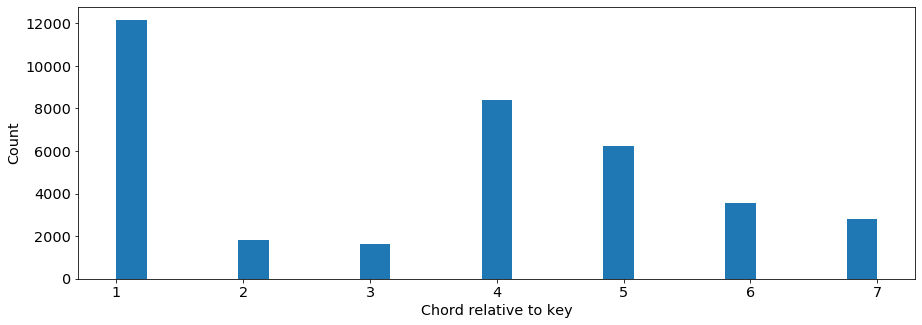

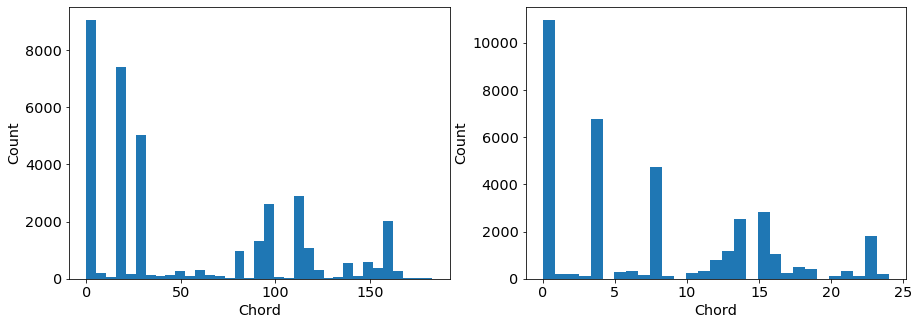

In [10]:

plt.hist(super_sequence, bins='auto')
#plt.colorbar()
plt.xlabel('Chord relative to key')
plt.ylabel('Count')
plt.show()

plt.subplot(1, 2, 1)
plt.hist(roman_as_num, bins='auto')
#plt.colorbar()
plt.xlabel('Chord')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(chord_seq, bins='auto')
#plt.colorbar()
plt.xlabel('Chord')
plt.ylabel('Count')
plt.savefig('plots/chord_hist.png')
plt.show()

(36570, 1)
(36570, 2)


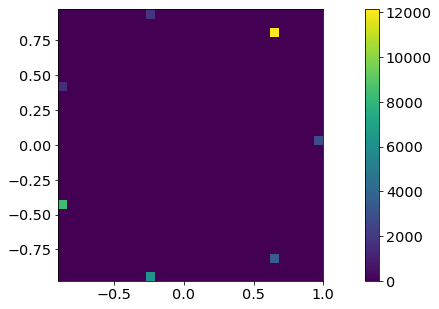

In [4]:
# Convert to radians.
chord_rad = 2*np.pi*super_sequence / 7

chord_x = np.cos(chord_rad).reshape(-1, 1)
chord_y = np.sin(chord_rad).reshape(-1, 1)
chord_vec = np.hstack((chord_x, chord_y))
h, xedges, yedges, image = plt.hist2d(chord_vec[:, 0], chord_vec[:, 1], bins=(30, 30))
plt.colorbar()
plt.xlim(0, 1)
plt.ylim(0, 1)
ax = plt.gca()
ax.axis('tight')
ax.set_aspect('equal', adjustable='box')

In [33]:
num_features = len(common_chords)
sequence_length = 8
lstm1_size = 64
lstm2_size = 64
dropout = 0.3

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(lstm1_size, return_sequences=True, input_shape=(sequence_length, len(common_chords))))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.LSTM(lstm2_size))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(num_features, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
# define the checkpoint

In [34]:
full_sequence = chord_cat
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
#lstm_model.compile(loss=tf.losses.CategoricalCrossentropy())
#feedback_model.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

In [35]:
train_split = 0.7
split_idx = int(train_split * full_sequence.shape[0])
input_seq = full_sequence[:-sequence_length]
targets = full_sequence[sequence_length:]
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input_seq, targets, sequence_length=sequence_length, sequence_stride=2, sampling_rate=1,
    batch_size=32, shuffle=True, seed=1337, start_index=None, end_index=split_idx
)
val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input_seq, targets, sequence_length=sequence_length, sequence_stride=2, sampling_rate=1,
    batch_size=32, shuffle=True, seed=1337, start_index=split_idx, end_index=None
)

for batch, labels in train_dataset:
    print(batch.shape, labels.shape)
    break
for batch, labels in val_dataset:
    print(batch.shape, labels.shape)
    break

(32, 8, 25) (32, 25)
(32, 8, 25) (32, 25)


In [36]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)
loss, accuracy = model.evaluate(val_dataset, batch_size=32)
model.save(f'models/seq_{sequence_length}-lay_{lstm1_size}_{lstm2_size}_{dropout}-voc_{len(common_chords)}-loss_{loss}-acc_{accuracy}')

Epoch 1/20
400/400 [==============================] - 9s 24ms/step - loss: 2.0399 - accuracy: 0.3346 - val_loss: 1.9989 - val_accuracy: 0.3436
Epoch 2/20
400/400 [==============================] - 7s 17ms/step - loss: 1.7851 - accuracy: 0.3907 - val_loss: 1.9500 - val_accuracy: 0.3381
Epoch 3/20
400/400 [==============================] - 7s 17ms/step - loss: 1.6831 - accuracy: 0.4371 - val_loss: 1.8457 - val_accuracy: 0.3726
Epoch 4/20
400/400 [==============================] - 7s 17ms/step - loss: 1.5729 - accuracy: 0.4985 - val_loss: 1.7823 - val_accuracy: 0.4001
Epoch 5/20
400/400 [==============================] - 6s 16ms/step - loss: 1.4943 - accuracy: 0.5306 - val_loss: 1.7109 - val_accuracy: 0.4538
Epoch 6/20
400/400 [==============================] - 7s 18ms/step - loss: 1.4372 - accuracy: 0.5535 - val_loss: 1.6693 - val_accuracy: 0.4681
Epoch 7/20
400/400 [==============================] - 7s 16ms/step - loss: 1.3697 - accuracy: 0.5772 - val_loss: 1.6244 - val_accuracy: 0.4945

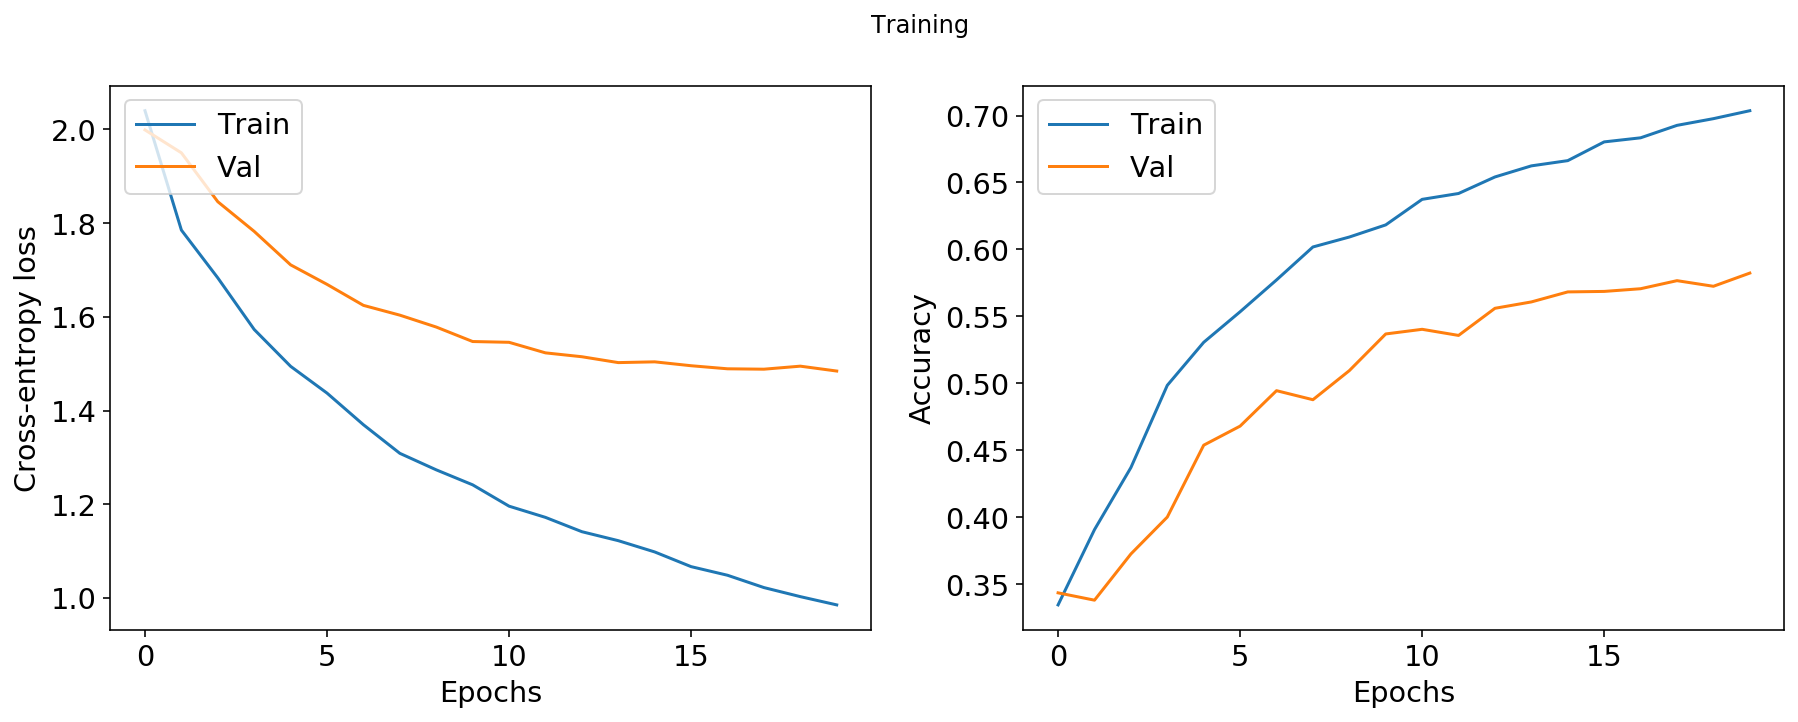

test loss 1.484276294708252 test acc 0.5823293328285217


In [37]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.suptitle('Training')
plt.ylabel('Cross-entropy loss')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.savefig('plots/train.png')
plt.show()
print("test loss", loss, "test acc", accuracy)

In [38]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8, 64)             23040     
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1625      
Total params: 57,689
Trainable params: 57,689
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
def predict_chords(warmup_start_idx=0, num_chords=16):
    warmup_length = sequence_length
    series_slice = full_sequence[warmup_start_idx : warmup_start_idx + warmup_length]
    warmup_series = np.expand_dims(series_slice, 0)
    #warmup_series = series_slice.reshape((batches, sequence_length, -1))
    warmup_chords = np.argmax(warmup_series, axis=-1)[0]
    #print(warmup_chords.shape)
    warmup_chords_roman = common_chords[warmup_chords]
    print(warmup_chords_roman)
    generated = feedback_model.generate(warmup_series, out_steps=64)
    #print(generated.shape)
    #print(generated)
    window_size = int(warmup_length / 1)
    sequence = np.copy(warmup_series[:, :window_size])
    pred_chords = []
    model.reset_states()
    for i in range(num_chords):
        prediction = model.predict(sequence)[0]
        #pred_chord = np.argmax(prediction)
        pred_chord = np.random.choice(len(prediction), p=prediction)
        pred_chords.append(pred_chord)
        sequence[:, :-1] = sequence[:, 1:]
        sequence[:, -1] = prediction[0]
        #print(np.argmax(sequence, axis=-1)[0] + 1)
    pred_chords_roman = common_numerals[chords]
    #print(pred_chords_roman)
    return pred_chords

chords = []
num_chords = 512
batches = 1
jump = num_chords*2
#np.random.seed(1337)
start_idx = np.random.randint(0, len(full_sequence)-2000)
end_idx = start_idx + batches*jump
for i in range(start_idx, end_idx, jump):
    pred_chords = predict_chords(i, num_chords=num_chords)
    chords.extend(pred_chords)

[  1  16 154  16   1  16 154  16]


In [48]:
from music21 import *#roman, stream, midi, duration, key
from datetime import datetime
chord_to_major_roman = ['I', 'ii', 'iii', 'IV', 'V', 'vi', 'vii']
#roman_numerals = [chord_to_major_roman[chord] for chord in chords]
roman_numerals = common_numerals[chords]
print(roman_numerals)
roman_chords = map(roman.RomanNumeral, roman_numerals)
chords_part = stream.Part()
chords_part.insert(0, instrument.Piano())
#chords_part.keySignature = key.Key('Em')
bass_part = stream.Part()
bass_part.insert(0, instrument.Bass())
#bass_part.keySignature = key.Key('Em')
for roman_chord in roman_chords:
    roman_chord.duration = duration.Duration(8)
    chords_part.append(roman_chord)
    bass_pitch = roman_chord.bass().transpose(-12)
    bass_note = note.Note(bass_pitch)
    bass_note.duration = duration.Duration(4)
    bass_part.append(bass_note)
    bass_note = note.Note(bass_pitch)
    bass_note.duration = duration.Duration(4)
    bass_part.append(bass_note)
score = stream.Score((chords_part, bass_part))
#score.keySignature = key.Key('Em')
score.show('midi')
score.write('midi', f'output/score-{datetime.now()}.mid')

['I' 'v' 'v' 'IV6' 'I' 'v' 'v' 'V11' 'I64' 'I64' 'I' 'I64' 'ii7' 'ii7'
 'I64' 'V6' 'V6' 'ii7' 'I' 'V11' 'V11' 'ii7' 'vi' 'I' 'I' 'I' 'IV64' 'I'
 'V11' 'V11' 'IVd7' 'I' 'V11' 'I' 'I64' 'I' 'IVd7' 'V11' 'ii7' 'V6' 'I64'
 'I64' 'vi' 'I64' 'vi' 'I64' 'v' 'V11' 'ii7' 'V11' 'V11' 'V11' 'vi' 'V11'
 'V11' 'ii7' 'ii' 'V6' 'ii7' 'I64' 'vi' 'V11' 'V6' 'I64' 'II' 'I64' 'vi'
 'V11' 'I64' 'V11' 'vi' 'V11' 'I64' 'I64' 'ii7' 'iv' 'vi' 'iii' 'vi' 'V11'
 'I64' 'V11' 'I64' 'vi' 'IV6' 'I64' 'V11' 'IV6' 'IVd7' 'V11' 'I64' 'V11'
 'vi' 'IVd7' 'ii7' 'ii7' 'vi' 'I64' 'vi' 'vi' 'I64' 'V11' 'vi' 'vi' 'vi'
 'V7' 'V11' 'ii7' 'I64' 'I6' 'iv' 'vi7' 'IV6' 'I64' 'I64' 'IVd7' 'V11'
 'I64' 'V11' 'ii' 'I64' 'V11' 'I64' 'V11' 'I' 'I64' 'I64' 'I64' 'I64'
 'I64' 'ii' 'V11' 'ii7' 'ii7' 'V11' 'iii' 'vi7' 'V11' 'I64' 'I64' 'vi'
 'I6' 'ii7' 'I64' 'I64' 'I64' 'II' 'I64' 'IVd7' 'V11' 'ii7' 'vi' 'I64'
 'V11' 'ii7' 'ii7' 'V11' 'I64' 'V6' 'ii7' 'I64' 'IV' 'V' 'V' 'bVII' 'IV64'
 'I64' 'V11' 'v7' 'ii7' 'I64' 'I64' 'vi' 'I64' 'V' 'V11'

'output/score-2020-10-26 18:38:02.532063.mid'

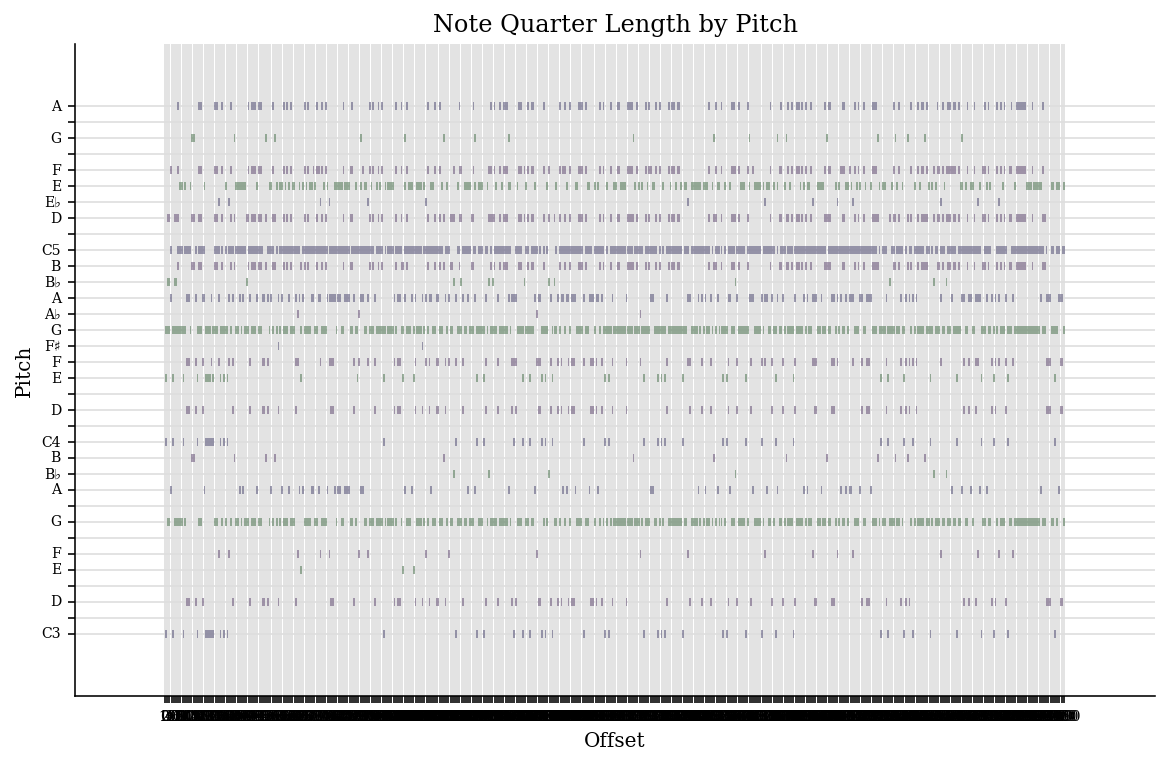

In [49]:
score.plot()
plt.savefig('plots/midi.png')

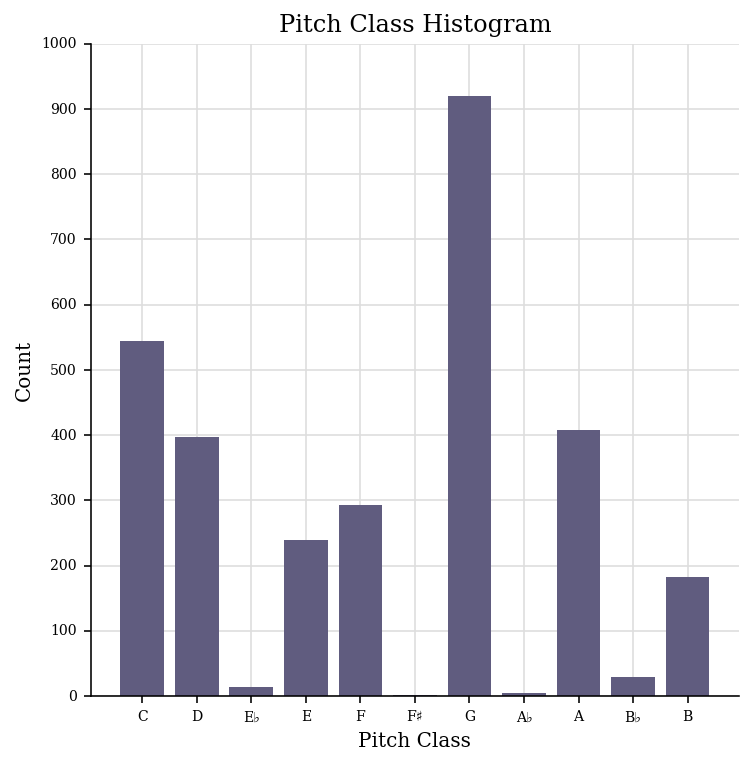

In [50]:
score.plot('histogram', 'pitchClass')
plt.savefig('plots/pitch_hist.png')

In [28]:
#sp = midi.realtime.StreamPlayer(score)
#sp.play()